In [1]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline
labelsize = 22
mpl.rcParams.update({'font.size': labelsize})
mpl.rcParams.update({'figure.figsize': (20,10)})
mpl.rcParams.update({'axes.titlesize': 'large'})
mpl.rcParams.update({'axes.labelsize': 'large'})
mpl.rcParams.update({'xtick.labelsize': labelsize})
mpl.rcParams.update({'ytick.labelsize': labelsize})

In [2]:
!cd data && ls

2014-05 - Citi Bike trip data.csv
bike_20140505_with_dist_and_avg_velo.csv
bike_20140505_with_dist.csv
bike_20140505_with_dist_velo.csv
bike_oneweekfrom20140505.csv
data_jan13.csv
README.txt
Taxi_from_2013-05-06_to_2013-05-13.csv
Taxi_from_2013-05-06_to_2013-05-13_testset.csv
Taxi_from_2013-05-06_to_2013-05-13testset.csv
Taxi_from_2013-05-06_to_2013-05-13_xtrain.csv
Taxi_from_2013-05-06_to_2013-05-13_ytrain.csv
taxi_oneweekfrom20130107.csv
taxi_oneweekfrom20130506.csv
taxi_oneweekfrom20140505.csv
taxi_tree_test_X_20130506-12.csv
taxi_tree_test_X.csv
taxi_tree_test_Xy_20130506-12.csv
taxi_tree_test_Xy.csv
taxi_tree_test_Xy_sample.csv
taxi_tree_test_y_20130506-12.csv
taxi_tree_test_y.csv
_testset.csv
yellow_tripdata_2013-05.csv
yellow_tripdata_2014-05.csv


Use the bash =)

In [3]:
data = pd.read_csv('data/bike_oneweekfrom20140505.csv', index_col=0, parse_dates=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185744 entries, 0 to 185743
Data columns (total 15 columns):
tripduration               185744 non-null int64
starttime                  185744 non-null object
stoptime                   185744 non-null object
start station id           185744 non-null int64
start station name         185744 non-null object
start station latitude     185744 non-null float64
start station longitude    185744 non-null float64
end station id             185744 non-null int64
end station name           185744 non-null object
end station latitude       185744 non-null float64
end station longitude      185744 non-null float64
bikeid                     185744 non-null int64
usertype                   185744 non-null object
birth year                 185744 non-null object
gender                     185744 non-null int64
dtypes: float64(4), int64(5), object(6)
memory usage: 22.7+ MB


So parsing doe not work, do it manually:

In [5]:
data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [6]:
new_column_names = ['trip_time', 'pickup_datetime', 'dropoff_datetime', 'start_station_id',
       'start_station_name', 'pickup_latitude',
       'pickup_longitude', 'end_station_id', 'end_station_name',
       'dropoff_latitude', 'dropoff_longitude', 'bikeid', 'usertype',
       'birth year', 'gender']

In [7]:
data.columns = new_column_names

In [8]:
data.describe()

,trip_time,start_station_id,pickup_latitude,pickup_longitude,end_station_id,dropoff_latitude,dropoff_longitude,bikeid,gender
count,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000
mean,869.523107,450.726511,40.734630,-73.991079,451.404142,40.734387,-73.991147,18157.530305,1.090598
std,974.098663,370.232259,0.019489,0.012186,375.448276,0.019530,0.012298,2119.989210,0.550519
min,60.000000,72.000000,40.680342,-74.017134,72.000000,40.680342,-74.017134,14529.000000,0.000000
25%,401.000000,304.000000,40.721655,-73.999947,303.000000,40.721101,-74.000040,16315.000000,1.000000
50%,640.000000,405.000000,40.736494,-73.990765,404.000000,40.736197,-73.990931,18164.000000,1.000000
75%,1059.000000,490.000000,40.750073,-73.982050,489.000000,40.749718,-73.982050,20005.000000,1.000000
max,21549.000000,3002.000000,40.771522,-73.953809,3002.000000,40.771522,-73.953809,21679.000000,2.000000


In [9]:
data['pickup_datetime'] =pd.to_datetime(data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] =pd.to_datetime(data['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['trip_time'] = pd.to_timedelta(data['trip_time'], 's')

In [10]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trip_time,185744,0 days 00:14:29.523107,0 days 00:16:14.098662,0 days 00:01:00,0 days 00:06:41,0 days 00:10:40,0 days 00:17:39,0 days 05:59:09
start_station_id,185744,450.727,370.232,72,304,405,490,3002
pickup_latitude,185744,40.7346,0.0194894,40.6803,40.7217,40.7365,40.7501,40.7715
pickup_longitude,185744,-73.9911,0.012186,-74.0171,-73.9999,-73.9908,-73.9821,-73.9538
end_station_id,185744,451.404,375.448,72,303,404,489,3002
dropoff_latitude,185744,40.7344,0.0195297,40.6803,40.7211,40.7362,40.7497,40.7715
dropoff_longitude,185744,-73.9911,0.0122976,-74.0171,-74,-73.9909,-73.9821,-73.9538
bikeid,185744,18157.5,2119.99,14529,16315,18164,20005,21679
gender,185744,1.0906,0.550519,0,1,1,1,2


In [11]:
data.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1
2,00:03:57,2014-05-05 00:01:05,2014-05-05 00:05:02,309,Murray St & West St,40.714979,-74.013012,3002,South End Ave & Liberty St,40.711512,-74.015756,18008,Customer,\N,0
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1
4,00:04:35,2014-05-05 00:01:16,2014-05-05 00:05:51,173,Broadway & W 49 St,40.760647,-73.984427,449,W 52 St & 9 Ave,40.764618,-73.987895,16607,Subscriber,1985,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185744 entries, 0 to 185743
Data columns (total 15 columns):
trip_time             185744 non-null timedelta64[ns]
pickup_datetime       185744 non-null datetime64[ns]
dropoff_datetime      185744 non-null datetime64[ns]
start_station_id      185744 non-null int64
start_station_name    185744 non-null object
pickup_latitude       185744 non-null float64
pickup_longitude      185744 non-null float64
end_station_id        185744 non-null int64
end_station_name      185744 non-null object
dropoff_latitude      185744 non-null float64
dropoff_longitude     185744 non-null float64
bikeid                185744 non-null int64
usertype              185744 non-null object
birth year            185744 non-null object
gender                185744 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(4), object(4), timedelta64[ns](1)
memory usage: 22.7+ MB


Amount of stations: 326


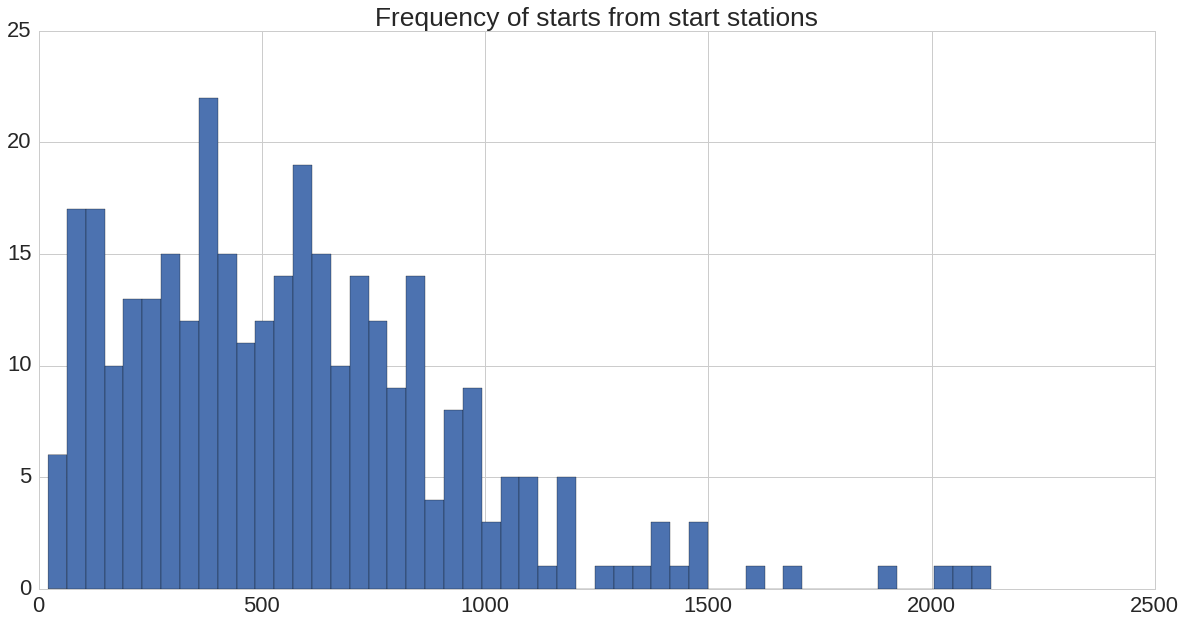

In [13]:
group_by_start = data.groupby(data.start_station_id, )
usage_freq = group_by_start.trip_time.count()
print('Amount of stations: ' + str(len(usage_freq)))
plt.hist(usage_freq, bins = 50)
plt.title('Frequency of starts from start stations')

Return the most frequently visited stations.

In [14]:
group_by_start_name = data.groupby(data.start_station_name, )
usage_freq_name = group_by_start_name.trip_time.count()
usage_freq_name.sort_values().keys()[-10:]

Index(['Greenwich Ave & 8 Ave', 'Broadway & W 24 St', '8 Ave & W 33 St',
       'Broadway & E 14 St', 'W 21 St & 6 Ave', 'West St & Chambers St',
       'E 17 St & Broadway', 'Lafayette St & E 8 St', '8 Ave & W 31 St',
       'E 42 St & Vanderbilt Ave'],
      dtype='object', name='start_station_name')

In [15]:
usage_freq_name.sort_values().keys()

Index(['Clinton Ave & Flushing Ave', 'Railroad Ave & Kay Ave',
       'Hanover Pl & Livingston St', 'Park Ave & St Edwards St',
       'Monroe St & Classon Ave', 'Sands St & Navy St',
       'Bedford Ave & S 9th St', 'DeKalb Ave & Skillman St',
       'Carlton Ave & Park Ave', 'Gallatin Pl & Livingston St',
       ...
       'Greenwich Ave & 8 Ave', 'Broadway & W 24 St', '8 Ave & W 33 St',
       'Broadway & E 14 St', 'W 21 St & 6 Ave', 'West St & Chambers St',
       'E 17 St & Broadway', 'Lafayette St & E 8 St', '8 Ave & W 31 St',
       'E 42 St & Vanderbilt Ave'],
      dtype='object', name='start_station_name', length=326)

So we have 326 different start stations.

In [16]:
group_by_end_name = data.groupby(data.end_station_name, )
usage_freq_name = group_by_end_name.trip_time.count()
usage_freq_name.sort_values().keys()

Index(['Railroad Ave & Kay Ave', 'Clinton Ave & Flushing Ave',
       'Greenwich St & N Moore St', 'Hanover Pl & Livingston St',
       'Park Ave & St Edwards St', 'Sands St & Navy St',
       'Monroe St & Classon Ave', 'Bedford Ave & S 9th St',
       'Carlton Ave & Park Ave', 'E 4 St & 2 Ave',
       ...
       'Broadway & W 24 St', 'Broadway & W 60 St', 'University Pl & E 14 St',
       'Greenwich Ave & 8 Ave', 'W 21 St & 6 Ave', 'E 42 St & Vanderbilt Ave',
       'West St & Chambers St', 'Lafayette St & E 8 St', 'E 17 St & Broadway',
       '8 Ave & W 31 St'],
      dtype='object', name='end_station_name', length=326)

We have 326 different end stations, too. But are all end_stations contained in start_stations and vive versa? 

In [17]:
group_by_start_id = data.groupby(data.start_station_id, )
start_ids = group_by_start_id.trip_time.count().sort_values().keys()
group_by_end_id = data.groupby(data.end_station_id, )
end_ids = group_by_end_id.trip_time.count().sort_values().keys()
len(set(start_ids).intersection(end_ids))

326

So this is the proof, that all stations are used as start and end stations.

# Check for missing and false data:

In [18]:
data.isnull().sum()

trip_time             0
pickup_datetime       0
dropoff_datetime      0
start_station_id      0
start_station_name    0
pickup_latitude       0
pickup_longitude      0
end_station_id        0
end_station_name      0
dropoff_latitude      0
dropoff_longitude     0
bikeid                0
usertype              0
birth year            0
gender                0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [19]:
(data==0).sum()

trip_time                 0
pickup_datetime           0
dropoff_datetime          0
start_station_id          0
start_station_name        0
pickup_latitude           0
pickup_longitude          0
end_station_id            0
end_station_name          0
dropoff_latitude          0
dropoff_longitude         0
bikeid                    0
usertype                  0
birth year                0
gender                20495
dtype: int64

So we only have many zeros in the gender-feature. But gender is a binary variable, therefore a 0 is not equal to NA.

Quick pverview about the trip_times

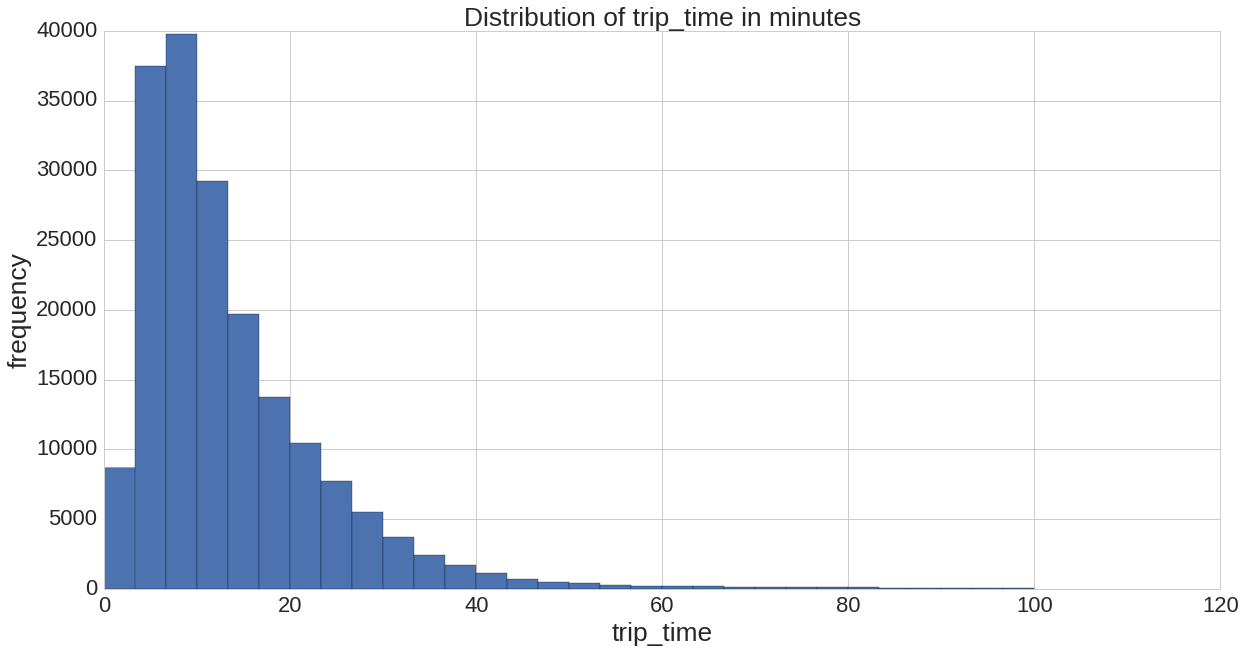

In [20]:
plt.hist((data['trip_time'] / np.timedelta64(1, 'm')), bins=30, range=[0, 100])
plt.title('Distribution of trip_time in minutes')
plt.xlabel('trip_time')
plt.ylabel('frequency')
plt.savefig('figures/bike_trip_time.png', format='png', dpi=300)

We are interested in the trip time in minutes.

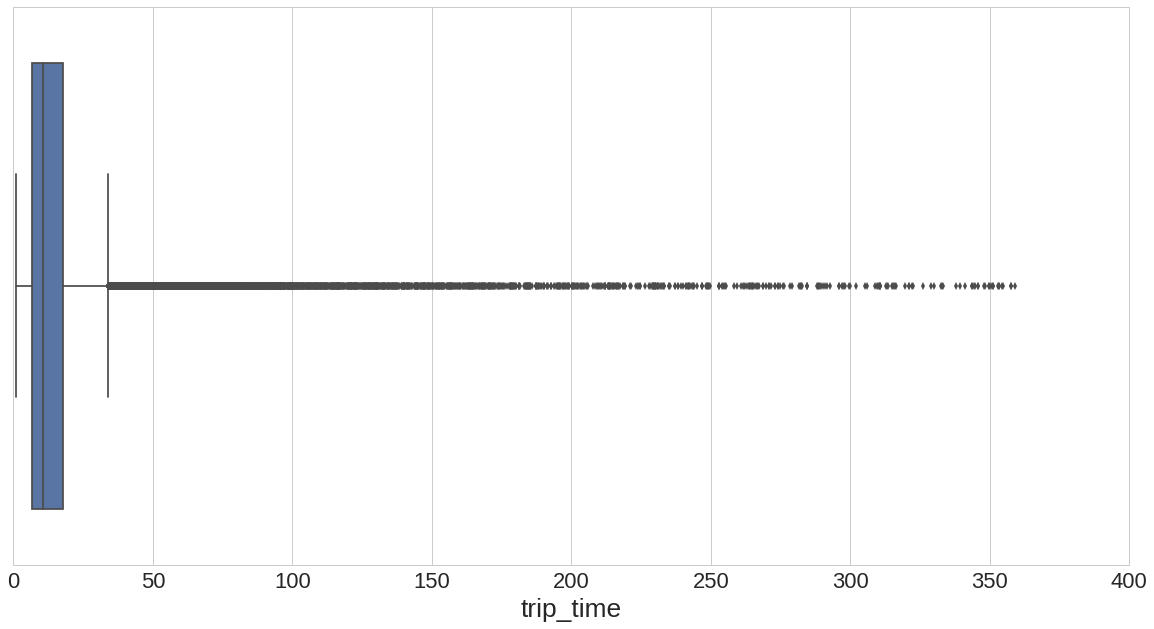

In [21]:
sns.boxplot((data['trip_time'] / np.timedelta64(1, 'm')))

We have lots of outliers.

So as we can see, we have many outliers.

In [22]:
data.trip_time.quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.01          00:01:59
0.05          00:03:25
0.10          00:04:25
0.25          00:06:41
0.50          00:10:40
0.75          00:17:39
0.90          00:26:54
0.95          00:33:56
0.99   01:08:57.570000
Name: trip_time, dtype: timedelta64[ns]

In [23]:
len(data.trip_time.value_counts().values)

5353

Identify the the cases without geo data and remove them from our data to be processed.

In [24]:
anomaly = data.loc[(data['dropoff_longitude'].isnull()) | (data['dropoff_latitude'].isnull()) | 
                       (data['pickup_longitude'].isnull()) | (data['pickup_latitude'].isnull())]
data = data.drop(anomaly.index)

In [25]:
anomaly['flag'] = 'geo_NA'

In [26]:
data.isnull().sum()

trip_time             0
pickup_datetime       0
dropoff_datetime      0
start_station_id      0
start_station_name    0
pickup_latitude       0
pickup_longitude      0
end_station_id        0
end_station_name      0
dropoff_latitude      0
dropoff_longitude     0
bikeid                0
usertype              0
birth year            0
gender                0
dtype: int64

So how many percent of data are left to be processed?

In [27]:
len(data)/(len(data)+len(anomaly))

1.0

In [28]:
anomaly.tail()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,flag


# <font color = 'blue'> So we dropped nothing because of missing geo tags. </font color>

(array([  1886.,  12429.,  23265.,  25474.,  22858.,  18987.,  14736.,
         11772.,   9414.,   7721.,   6635.,   5540.,   4620.,   3809.,
          3101.,   2403.,   1852.,   1427.,   1223.,    958.,    755.,
           558.,    395.,    337.,    307.,    247.,    231.,    180.,
           141.,    134.,    124.,    122.,    134.,     72.,     84.,
            67.,     79.,     63.,     59.,     71.,     61.,     59.,
            42.,     47.,     37.,     37.,     41.,     47.,     38.,
            43.]),
 array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
          18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
          36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
          54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
          72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
          90.,   92.,   94.,   96.,   98.,  100.]),
 <a list of 50 Patch objects>)

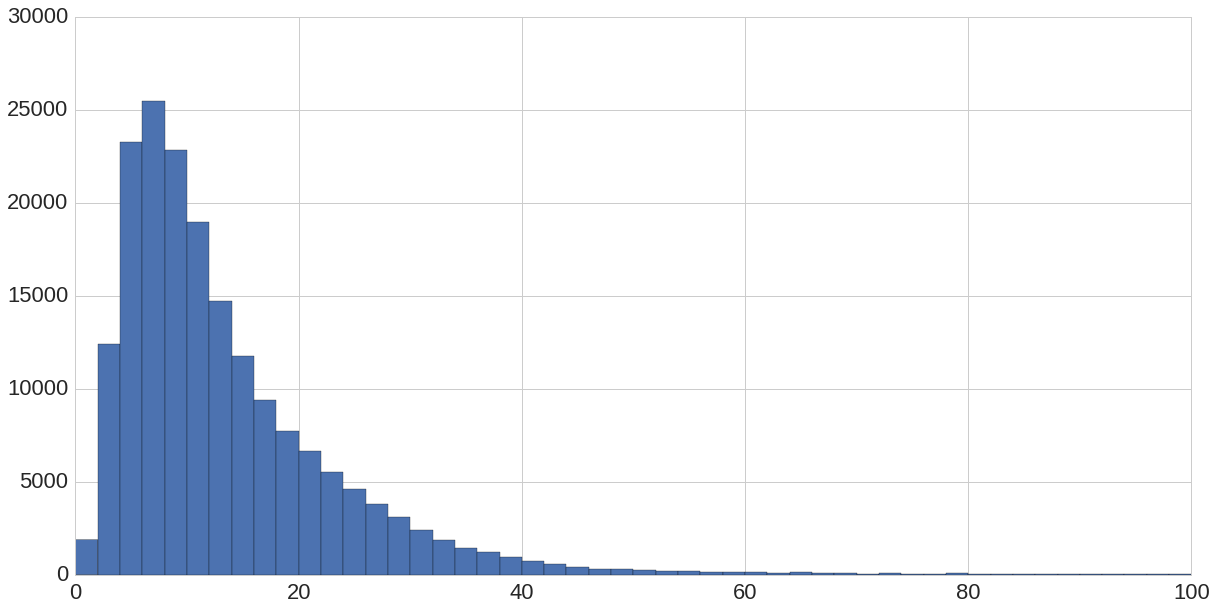

In [29]:
plt.hist(data.trip_time.values / np.timedelta64(1, 'm'), bins=50, range=[0,100])

# We sometimes have some unreasonably small trip_times.

Calculate the distance of a trip. Use the difference of lon / lat data and parse it to metrics.

In [30]:
data['trip_dist'] = -1 # Init trip_dist

In [31]:
# inpout for vincenty:(location.latitude, location.longitude)
from geopy.distance import vincenty
for i in range(0, (len(data)-1)):
    pickup = (data.iloc[i]['pickup_latitude'], data.iloc[i]['pickup_longitude'])
    dropoff = (data.iloc[i]['dropoff_latitude'], data.iloc[i]['dropoff_longitude'])
    data.set_value(i, 'trip_dist', vincenty(pickup,dropoff).meters)

# <font color = 'red'> This operation is quite slow! </font color>

In [32]:
data.trip_dist

0          876
1         4153
2          449
3         1630
4          529
5          760
6         1332
7         2297
8          689
9         1371
10        2358
11         558
12        4488
13        2146
14        2803
15        1291
16         446
17        1721
18        2882
19         674
20         927
21        3635
22        2168
23         887
24         810
25         706
26         810
27        1491
28        1003
29         935
          ... 
185714       0
185715     552
185716    2067
185717    1646
185718     535
185719     722
185720     366
185721     565
185722    1839
185723     809
185724       0
185725    1682
185726    1348
185727    1244
185728     739
185729    1314
185730    1154
185731    1694
185732    1896
185733    1061
185734    1208
185735     919
185736    1187
185737     285
185738     285
185739     831
185740     908
185741    1273
185742     906
185743      -1
Name: trip_dist, dtype: int64

We cannot use miles because vincenty ceils / floors the results

In [33]:
data.columns

Index(['trip_time', 'pickup_datetime', 'dropoff_datetime', 'start_station_id',
       'start_station_name', 'pickup_latitude', 'pickup_longitude',
       'end_station_id', 'end_station_name', 'dropoff_latitude',
       'dropoff_longitude', 'bikeid', 'usertype', 'birth year', 'gender',
       'trip_dist'],
      dtype='object')

Check if new column is present

In [34]:
data.to_csv('data/bike_20140505_with_dist.csv')

In [35]:
data['avg_velocity'] = data.trip_dist.values/(data.trip_time / (np.timedelta64(1, 'h')))

In [36]:
data.avg_velocity

0         10912.110727
1         14225.309229
2          6820.253165
3         10988.764045
4          6925.090909
5          8658.227848
6         12787.200000
7         13713.432836
8          9119.117647
9          7466.868381
10         7867.284523
11         9611.483254
12        10785.580774
13         6966.275924
14         9628.625954
15        11199.036145
16         9122.727273
17        11388.970588
18        13963.930013
19         8543.661972
20        13565.853659
21        11061.707523
22        11086.363636
23         5357.718121
24         9112.500000
25         7241.025641
26         9286.624204
27         3029.119639
28        13035.379061
29         9402.234637
              ...     
185714        0.000000
185715     4445.637584
185716    11554.658385
185717     8417.045455
185718     8754.545455
185719     6203.341289
185720    11870.270270
185721     6647.058824
185722     8631.551499
185723     8321.142857
185724        0.000000
185725    12883.404255
185726    1

Parse to km/h

In [37]:
data.avg_velocity = data.avg_velocity/1000

In [38]:
data.avg_velocity

0         10.912111
1         14.225309
2          6.820253
3         10.988764
4          6.925091
5          8.658228
6         12.787200
7         13.713433
8          9.119118
9          7.466868
10         7.867285
11         9.611483
12        10.785581
13         6.966276
14         9.628626
15        11.199036
16         9.122727
17        11.388971
18        13.963930
19         8.543662
20        13.565854
21        11.061708
22        11.086364
23         5.357718
24         9.112500
25         7.241026
26         9.286624
27         3.029120
28        13.035379
29         9.402235
            ...    
185714     0.000000
185715     4.445638
185716    11.554658
185717     8.417045
185718     8.754545
185719     6.203341
185720    11.870270
185721     6.647059
185722     8.631551
185723     8.321143
185724     0.000000
185725    12.883404
185726    11.637410
185727     8.514068
185728     6.964398
185729    13.751163
185730    12.861920
185731    11.818605
185732    11.376000


Convert avg_velocity from km/h to miles/h. (1km = 0,621371 miles)

In [39]:
data['avg_velocity'] = data.avg_velocity*0.627371

In [40]:
data.to_csv('data/bike_20140505_with_dist_and_avg_velo.csv')

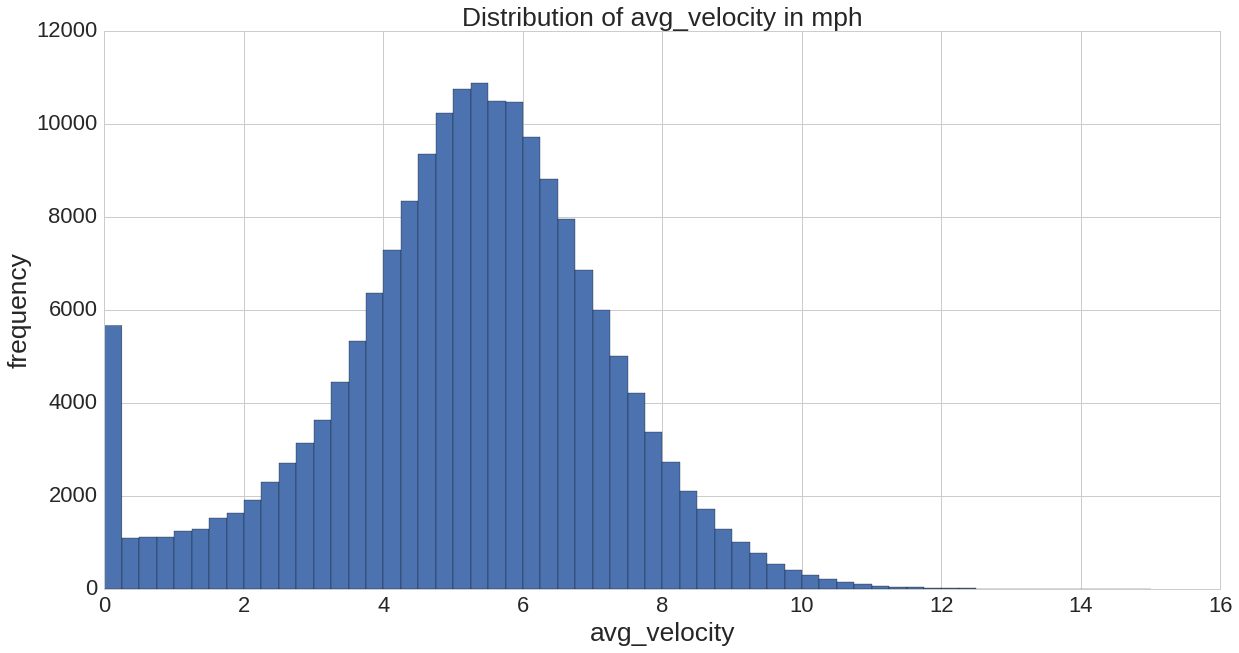

In [41]:
plt.hist(data.avg_velocity, bins=60, range=[0,15])
plt.title('Distribution of avg_velocity in mph')
plt.xlabel('avg_velocity')
plt.ylabel('frequency')
plt.savefig('figures/bike_avg_vel.png', format='png', dpi=300)

In [42]:
data.avg_velocity.describe() # in mph

count    185744.000000
mean          5.149069
std           2.023218
min          -0.006585
25%           4.068203
50%           5.306131
75%           6.457503
max          29.006050
Name: avg_velocity, dtype: float64

In [43]:
data.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1,876,6.845942
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1,4153,8.924546
2,00:03:57,2014-05-05 00:01:05,2014-05-05 00:05:02,309,Murray St & West St,40.714979,-74.013012,3002,South End Ave & Liberty St,40.711512,-74.015756,18008,Customer,\N,0,449,4.278829
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1,1630,6.894032
4,00:04:35,2014-05-05 00:01:16,2014-05-05 00:05:51,173,Broadway & W 49 St,40.760647,-73.984427,449,W 52 St & 9 Ave,40.764618,-73.987895,16607,Subscriber,1985,1,529,4.344601


In [44]:
data.avg_velocity.quantile([.0001,.01, .5, .75, .95, .975, .99, .995])

0.0001     0.000000
0.0100     0.000000
0.5000     5.306131
0.7500     6.457503
0.9500     8.198881
0.9750     8.802942
0.9900     9.514220
0.9950    10.012335
Name: avg_velocity, dtype: float64

# Be aware: We calculated the avg_velocity based on the euclidean distance. A real driver would never drive that fast. We take all avg_velos >= 5mph (approx. >5%-quantile) into account. We use an upper bound, too. It might not be possible to drive "too fast". If someone drives too fast, the technology has had a malfunction.

In [45]:
lb = 5
ub = 15
anomaly = data.loc[(data['avg_velocity'] < lb) | (data['avg_velocity'] > ub)] 

# be careful! Maybe adjust to append.
#anomaly.loc[
anomaly.loc[data.loc[(data['avg_velocity'] < lb)].index,'flag'] = 'too_slow'
anomaly.loc[data.loc[(data['avg_velocity'] > ub)].index,'flag'] = 'too_fast'
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(data)/(len(data)+len(anomaly)))

0.42908519252304245


/home/niklas/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/niklas/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# We dropped about 42% of the data!

In [46]:
data.avg_velocity.describe()

count    106044.000000
mean          6.502750
std           1.133101
min           5.000057
25%           5.616168
50%           6.269582
75%           7.142086
max          14.099118
Name: avg_velocity, dtype: float64

In [47]:
anomaly.tail()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity,flag
185728,00:06:22,2014-05-11 23:47:22,2014-05-11 23:53:44,308,St James Pl & Oliver St,40.713079,-73.998512,307,Canal St & Rutgers St,40.714275,-73.989900,19916,Subscriber,1983,1,739,4.369261,too_slow
185737,00:03:29,2014-05-11 23:50:54,2014-05-11 23:54:23,526,E 33 St & 5 Ave,40.747659,-73.984907,498,Broadway & W 32 St,40.748549,-73.988084,16197,Customer,\N,0,285,3.079821,too_slow
185738,00:03:09,2014-05-11 23:51:22,2014-05-11 23:54:31,526,E 33 St & 5 Ave,40.747659,-73.984907,498,Broadway & W 32 St,40.748549,-73.988084,14714,Customer,\N,0,285,3.405728,too_slow
185739,00:06:44,2014-05-11 23:52:29,2014-05-11 23:59:13,369,Washington Pl & 6 Ave,40.732241,-74.000264,293,Lafayette St & E 8 St,40.730287,-73.990765,14617,Subscriber,1962,1,831,4.645651,too_slow
185743,00:05:43,2014-05-11 23:53:44,2014-05-11 23:59:27,439,E 4 St & 2 Ave,40.726281,-73.989780,393,E 5 St & Avenue C,40.722992,-73.979955,15825,Customer,\N,0,-1,-0.006585,too_slow


# A little drawing

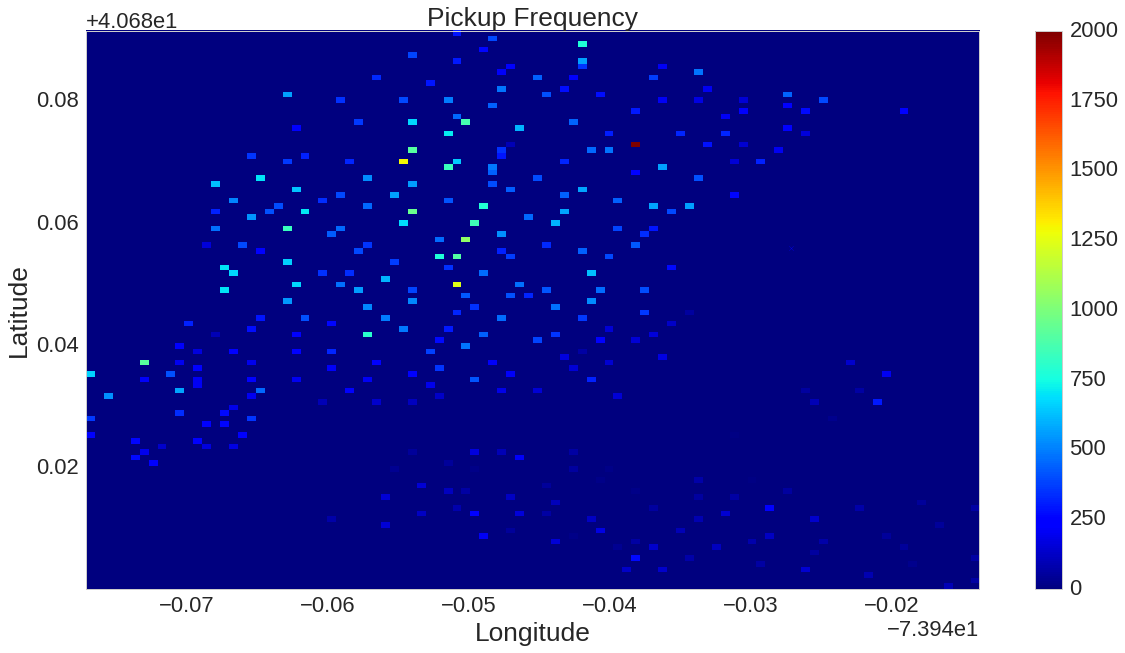

In [48]:
x = data.pickup_longitude
y = data.pickup_latitude

bins = 100;
#H, xedges, yedges = np.histogram2d(x, y, bins=100, range=[ [x.quantile(.05), x.quantile(.95)], 
#        [y.quantile(.05), y.quantile(.95)]], normed=False, weights=None)
H, xedges, yedges = np.histogram2d(x, y, bins=bins)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
#mesh = plt.pcolormesh(X, Y, H)
plt.hist2d(x,y,bins=bins)
plt.colorbar()
plt.scatter(xedges[79], yedges[61], marker='x')
ax = fig.gca()
ax.grid(False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup Frequency')
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')
plt.savefig('figures/bike_stations.png', format='png', dpi=300)

Where is a pickup maximum?

In [49]:
np.amax(H)

2001.0

In [50]:
np.where(H==2001)

(array([61]), array([79]))

The area with the maximum pickups is around the Grand Central Terminal. Not very surprising.

In [51]:
yedges[79],xedges[61], 

(40.752374288829998, -73.978505949899997)

In [52]:
type(H)

numpy.ndarray

In [53]:
print(H.shape)
print(H.size)
print(H.max())

(100, 100)
10000
2001.0


In [54]:
print('Current bin width:')
print(vincenty((xedges[0], yedges[0]), (xedges[1], yedges[1])).meters)

Current bin width:
76.03394282270413


In [55]:
distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters

In [56]:
print('Sizes of all bins in meters:')
distances

Sizes of all bins in meters:


array([ 76.03394282,  76.03433763,  76.03473245,  76.03512728,
        76.03552212,  76.03591697,  76.03631184,  76.03670672,
        76.03710161,  76.03749651,  76.03789143,  76.03828635,
        76.03868129,  76.03907624,  76.0394712 ,  76.03986618,
        76.04026116,  76.04065616,  76.04105117,  76.04144619,
        76.04184122,  76.04223627,  76.04263132,  76.04302639,
        76.04342148,  76.04381656,  76.04421167,  76.04460679,
        76.04500191,  76.04539706,  76.04579221,  76.04618737,
        76.04658255,  76.04697773,  76.04737294,  76.04776815,
        76.04816337,  76.04855861,  76.04895385,  76.04934911,
        76.04974438,  76.05013966,  76.05053496,  76.05093027,
        76.05132558,  76.05172091,  76.05211626,  76.05251161,
        76.05290698,  76.05330235,  76.05369774,  76.05409315,
        76.05448856,  76.05488398,  76.05527942,  76.05567487,
        76.05607033,  76.05646581,  76.05686129,  76.05725679,
        76.05765229,  76.05804782,  76.05844335,  76.05

In [57]:
print(str(max(data.pickup_latitude)) +','+ str(max(data.pickup_longitude)))
print(str(max(data.dropoff_latitude)) +','+ str(max(data.dropoff_longitude)))

40.771522,-73.95380904
40.771522,-73.95380904


About 97% if the bins have no pickups (not surprising).

In [58]:
(H==0).sum()/H.size

0.96750000000000003

# Only look at trips in a given bounding box


In [59]:
jfk_geodata = (40.641547, -73.778118)
ridgefield_geodata = (40.856406, -74.020642)
data_in_box = data.loc[(data['dropoff_latitude'] > jfk_geodata[0]) & 
                       (data['dropoff_longitude'] < jfk_geodata[1]) &
                       (data['dropoff_latitude'] < ridgefield_geodata[0]) & 
                       (data['dropoff_longitude'] > ridgefield_geodata[1]) & 
                       (data['pickup_latitude'] > jfk_geodata[0]) & 
                       (data['pickup_longitude'] < jfk_geodata[1]) &
                       (data['pickup_latitude'] < ridgefield_geodata[0]) & 
                       (data['pickup_longitude'] > ridgefield_geodata[1])         
                       ]
# taxidata = taxidata.drop(anomaly.index)

In [60]:
len(data_in_box)/len(data)

1.0

# We lost no trips through the bounding box.

In [61]:
data_in_box.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1,876,6.845942
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1,4153,8.924546
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1,1630,6.894032
5,00:05:16,2014-05-05 00:01:22,2014-05-05 00:06:38,294,Washington Square E,40.730494,-73.995721,237,E 11 St & 2 Ave,40.730473,-73.986724,15545,Subscriber,1983,2,760,5.431921
6,00:06:15,2014-05-05 00:01:48,2014-05-05 00:08:03,346,Bank St & Hudson St,40.736529,-74.006180,375,Mercer St & Bleecker St,40.726795,-73.996951,18794,Subscriber,1973,1,1332,8.022318


# So we know that about 97% of the bins have 0 pickups in it. This was expected, because we have static stations only.

Let's take a first look at the distribution of the cleaned target variable which we want to estimate:

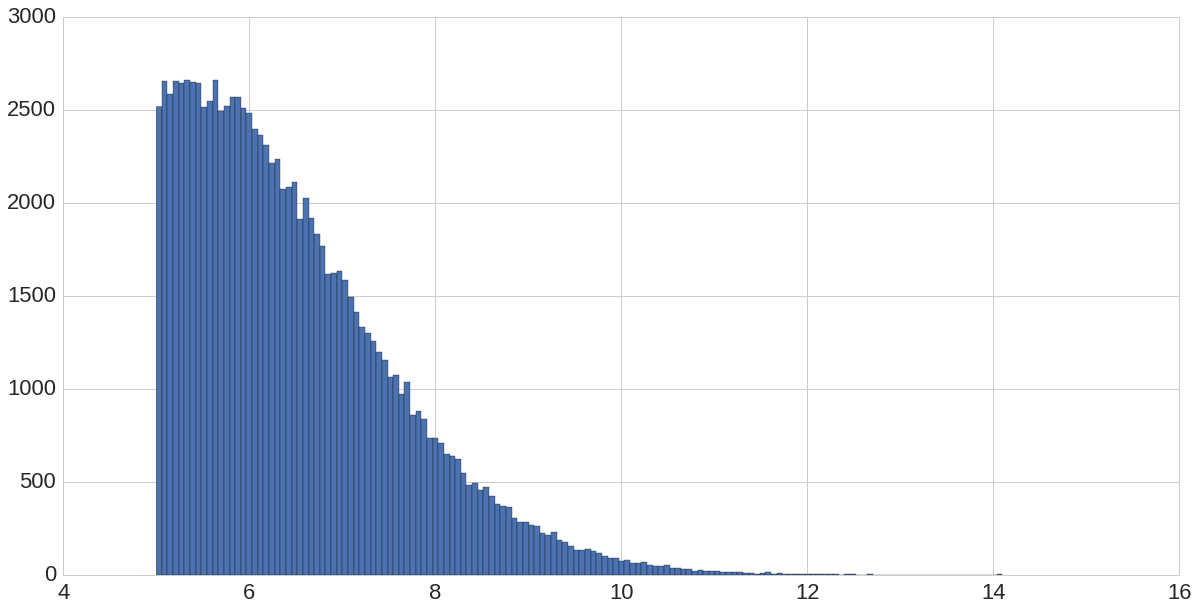

In [62]:
h = data_in_box.avg_velocity.values
plt.figure(figsize=(20,10))
plt.hist(h, normed=False,  bins=150)
    #, histtype='stepfilled')
#plt.yscale('log')
#plt.ylabel('log(freq x)', fontsize=40)
#plt.xlabel('x = avg_amount_per_minute', fontsize=40)
#print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
#plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [63]:
data_in_box.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1,876,6.845942
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1,4153,8.924546
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1,1630,6.894032
5,00:05:16,2014-05-05 00:01:22,2014-05-05 00:06:38,294,Washington Square E,40.730494,-73.995721,237,E 11 St & 2 Ave,40.730473,-73.986724,15545,Subscriber,1983,2,760,5.431921
6,00:06:15,2014-05-05 00:01:48,2014-05-05 00:08:03,346,Bank St & Hudson St,40.736529,-74.006180,375,Mercer St & Bleecker St,40.726795,-73.996951,18794,Subscriber,1973,1,1332,8.022318


# Make a new dataframe with features and targets

In [64]:
time_regression_df = pd.DataFrame([ #data_in_box['pickup_datetime'].dt.day, # leave this out
                          data_in_box['pickup_datetime'].dt.dayofweek,
                          data_in_box['pickup_datetime'].dt.hour,
                          data_in_box['pickup_latitude'],
                          data_in_box['pickup_longitude'],
                          data_in_box['dropoff_latitude'],
                          data_in_box['dropoff_longitude'],
                          np.ceil(data_in_box['avg_velocity'])
                         ]).T

In [65]:
time_regression_df.columns = [#'pickup_datetime_day', 
                              'pickup_datetime_dayofweek', 'pickup_datetime_hour',
                                 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
                                 'avg_velocity_mph']

Use minutes for prediction instead of seconds (ceil the time). Definitley more robust than seconds!

In [66]:
time_regression_df.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
0,0.0,0.0,40.762699,-73.993012,40.763441,-73.982681,7.0
1,0.0,0.0,40.764397,-73.973715,40.728419,-73.987140,9.0
3,0.0,0.0,40.721816,-73.997203,40.736494,-73.997044,7.0
5,0.0,0.0,40.730494,-73.995721,40.730473,-73.986724,6.0
6,0.0,0.0,40.736529,-74.006180,40.726795,-73.996951,9.0


In [67]:
time_regression_df.tail()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
185735,6.0,23.0,40.692395,-73.993379,40.688070,-73.984106,7.0
185736,6.0,23.0,40.707065,-74.007319,40.717488,-74.010455,9.0
185740,6.0,23.0,40.729170,-73.998102,40.721655,-74.002347,11.0
185741,6.0,23.0,40.734232,-73.986923,40.742909,-73.977061,9.0
185742,6.0,23.0,40.726281,-73.989780,40.722992,-73.979955,7.0


In [68]:
time_regression_df.ix[:,0:7].describe()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
count,106044.000000,106044.000000,106044.000000,106044.000000,106044.000000,106044.000000,106044.000000
mean,2.603636,13.969918,40.735199,-73.990941,40.734848,-73.991118,7.036636
std,1.972009,4.992480,0.019369,0.012164,0.019295,0.012357,1.125662
min,0.000000,0.000000,40.680342,-74.017134,40.680342,-74.017134,6.000000
25%,1.000000,9.000000,40.722174,-73.999733,40.722174,-74.000264,6.000000
50%,2.000000,15.000000,40.737050,-73.990765,40.737050,-73.990931,7.000000
75%,4.000000,18.000000,40.750200,-73.981948,40.749718,-73.982050,8.000000
max,6.000000,23.000000,40.771522,-73.953809,40.771522,-73.953809,15.000000


In [69]:
print(time_regression_df.avg_velocity_mph.value_counts())
print(len(time_regression_df.avg_velocity_mph.value_counts()))

6.0     42576
7.0     33360
8.0     18609
9.0      7849
10.0     2705
11.0      740
12.0      162
13.0       34
14.0        7
15.0        2
Name: avg_velocity_mph, dtype: int64
10


So we hace 10 different velocities to predict.

# Split the data into a training dataset and a test dataset. Evaluate the performance of the decision tree on the test data

In [70]:
from sklearn import cross_validation as cv
y = time_regression_df['avg_velocity_mph']
X = time_regression_df.ix[:,0:6]
X_train, X_test, y_train, y_test = cv.train_test_split(X, y,test_size=0.05,random_state=0) 

In [71]:
from sklearn import cross_validation as cv
time_regression_df_train, time_regression_df_test = cv.train_test_split(time_regression_df, test_size=0.05, random_state=99)
y_train = time_regression_df_train['avg_velocity_mph']
x_train = time_regression_df_train.ix[:, 0:6]
y_test = time_regression_df_test['avg_velocity_mph']
x_test = time_regression_df_test.ix[:, 0:6]

# Changed test size to 5%

In [72]:
x_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
38284,1.0,9.0,40.760203,-73.964785,40.756014,-73.967416
129690,4.0,17.0,40.757952,-73.977876,40.754557,-73.965930
109201,3.0,19.0,40.741444,-73.975361,40.725029,-73.990697
120605,4.0,11.0,40.722293,-73.991475,40.747659,-73.984907
89672,2.0,19.0,40.686919,-73.976682,40.683178,-73.965964


In [73]:
y_test.head()

38284     7.0
129690    8.0
109201    8.0
120605    7.0
89672     6.0
Name: avg_velocity_mph, dtype: float64

In [74]:
xy_test = pd.concat([x_test, y_test], axis=1)

In [75]:
xy_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
38284,1.0,9.0,40.760203,-73.964785,40.756014,-73.967416,7.0
129690,4.0,17.0,40.757952,-73.977876,40.754557,-73.965930,8.0
109201,3.0,19.0,40.741444,-73.975361,40.725029,-73.990697,8.0
120605,4.0,11.0,40.722293,-73.991475,40.747659,-73.984907,7.0
89672,2.0,19.0,40.686919,-73.976682,40.683178,-73.965964,6.0


If you want to export something...

In [76]:
#Xy_test.to_csv('taxi_tree_test_Xy_20130506-12.csv')
#X_test.to_csv('taxi_tree_test_X_20130506-12.csv')
#y_test.to_csv('taxi_tree_test_y_20130506-12.csv')
# Xy_test.to_csv('bike_tree_test_Xy_20140505-11.csv')
# X_test.to_csv('bike_tree_test_X_20140505-11.csv')
# y_test.to_csv('bike_tree_test_y_20140506-11.csv')

In [77]:
# Xy_test_sample = Xy_test.sample(10000, random_state=99)

In [78]:
# Xy_test_sample.to_csv('taxi_tree_test_Xy_sample.csv')

In [79]:
# Xy_test_sample.head()

Just to be sure

In [80]:
print(x_train.shape)
print(x_train.size)
print(x_test.shape)
print(x_train.shape[0]+x_test.shape[0])

(100741, 6)
604446
(5303, 6)
106044


In [81]:
print(__doc__)
import time
# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


In [82]:
regtree = DecisionTreeRegressor(min_samples_split=100, random_state=99, max_depth=20)# formerly 15. 15 is reasonable
                                                                                     # random states: 99
regtree.fit(x_train, y_train)

regtree.score(x_test, y_test)


0.11912472409623709

Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-3.10410581 -1.99446494 -1.4        -1.13986047 -0.56306818  0.19925743
  0.74845592  1.16598639  1.41176471  1.9564538 ]
Absolute time deviation (in 1k):  4.488221403


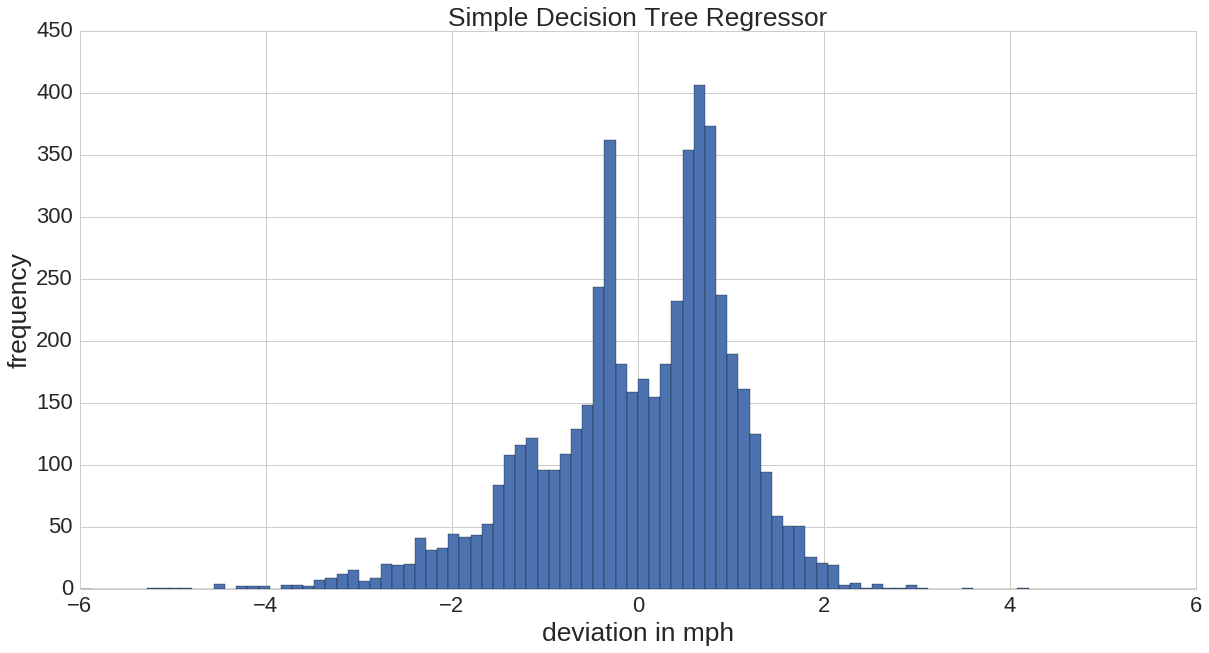

In [83]:
y_pred = regtree.predict(x_test)
diff_regtree = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff_regtree.values, bins=100, range=[-6,6])
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff_regtree.values, [1,5,10,15,25,50,75,90,95,99]))
print('Absolute time deviation (in 1k): ', sum(abs(diff_regtree))/1000)
plt.title('Simple Decision Tree Regressor')
plt.xlabel('deviation in mph')
plt.ylabel('frequency')
plt.savefig('figures/bike_tree.png', format='png', dpi=300)

In [84]:
diff_regtree.describe()

count    5303.000000
mean        0.003596
std         1.065819
min        -7.033333
25%        -0.563068
50%         0.199257
75%         0.748456
max         4.125000
Name: avg_velocity_mph, dtype: float64

# So this is a bad result. Let's try random forest now.

## Train several random forests and look at their scores

In [85]:
from sklearn.ensemble import RandomForestRegressor
n_est_list = list(range(2,32,8))
min_sam_leaf_list = [2,50,100,150]
max_depth_list = list(range(2,32,8))
results = np.empty([0,4])
for n_est in n_est_list:
    for min_sam_leaf in min_sam_leaf_list:
        for max_depth in max_depth_list:
            rd_regtree = RandomForestRegressor(n_estimators=n_est,n_jobs=6,min_samples_leaf=min_sam_leaf, random_state=99, max_depth=max_depth)
            rd_regtree.fit(x_train, y_train)
            score = rd_regtree.score(x_test, y_test)
            results = np.vstack((results, [n_est, min_sam_leaf, max_depth,score]))

In [86]:
best = np.where(results == max(results[:,3]))[0]
results[best,:]

array([[ 26.        ,   2.        ,  26.        ,   0.19979136]])

Watch at the best results.

In [87]:
results[np.argsort(results[:, 3])][-10:,:]

array([[ 26.        ,  50.        ,  18.        ,   0.16563993],
       [ 10.        ,  50.        ,  26.        ,   0.16709339],
       [ 18.        ,  50.        ,  26.        ,   0.17044882],
       [ 26.        ,  50.        ,  26.        ,   0.17190602],
       [ 10.        ,   2.        ,  26.        ,   0.17376701],
       [ 10.        ,   2.        ,  18.        ,   0.18050883],
       [ 18.        ,   2.        ,  18.        ,   0.18941467],
       [ 18.        ,   2.        ,  26.        ,   0.19121346],
       [ 26.        ,   2.        ,  18.        ,   0.196679  ],
       [ 26.        ,   2.        ,  26.        ,   0.19979136]])

In [88]:
results = np.vstack((results, [n_est, min_sam_leaf, max_depth,score]))
#results = np.vstack((results, [n_est, min_sam_leaf, max_depth,score]))
#results = np.vstack((results, [n_est, min_sam_leaf, max_depth,score]))
results[:,3]

array([ 0.03216565,  0.10243604,  0.05117017, -0.04134117,  0.03216565,
        0.10892762,  0.1338695 ,  0.13916637,  0.03216565,  0.10622744,
        0.12186341,  0.12444769,  0.03216565,  0.10673246,  0.12119634,
        0.12550215,  0.03273003,  0.14140097,  0.18050883,  0.17376701,
        0.03273003,  0.13053573,  0.16216698,  0.16709339,  0.03273003,
        0.12165977,  0.14658679,  0.14955706,  0.03273003,  0.11580282,
        0.13614928,  0.13957835,  0.03388217,  0.14354701,  0.18941467,
        0.19121346,  0.03388217,  0.13127777,  0.164049  ,  0.17044882,
        0.03388217,  0.1225744 ,  0.14795706,  0.15214733,  0.03388217,
        0.11604073,  0.13708992,  0.14088194,  0.03405952,  0.14412542,
        0.196679  ,  0.19979136,  0.03405952,  0.13139713,  0.16563993,
        0.17190602,  0.03405952,  0.12201824,  0.14815349,  0.15185501,
        0.03405952,  0.11595707,  0.13762175,  0.14100002,  0.14100002])

# Train the best random forest again seperately

In [89]:
from sklearn.ensemble import RandomForestRegressor

#rd_regtree = RandomForestRegressor(n_estimators=10,n_jobs=6,min_samples_leaf=4, random_state=99, max_depth=20)
rd_regtree = RandomForestRegressor(n_estimators=26,n_jobs=6,min_samples_leaf=2, random_state=99, max_depth=26)
#total sum of diff: 1132
#rd_regtree = RandomForestRegressor(n_estimators=40,n_jobs=-1,min_samples_split=3, random_state=99, max_depth=11)
#total sum of diff: 1129
rd_regtree.fit(x_train, y_train)
print('R²: ', rd_regtree.score(x_test, y_test))

R²:  0.199791363355


In [90]:
rd_regtree.feature_importances_

array([ 0.12104463,  0.17781704,  0.18620672,  0.16556891,  0.1811653 ,
        0.16819739])

In [91]:
tree_list = rd_regtree.estimators_
for i in range(0,len(tree_list)):
    print((tree_list[i].feature_importances_))


[ 0.12002358  0.17554296  0.19442978  0.17023113  0.17408755  0.165685  ]
[ 0.11671855  0.17003695  0.18261556  0.18056734  0.1770114   0.1730502 ]
[ 0.1212774   0.18594576  0.17974536  0.17083764  0.1721192   0.17007464]
[ 0.11802844  0.15425361  0.19237926  0.16592169  0.19164436  0.17777264]
[ 0.12216613  0.17483906  0.18325801  0.16611135  0.18617242  0.16745304]
[ 0.12681396  0.17850674  0.18685254  0.16952322  0.16825109  0.17005246]
[ 0.11894376  0.18112627  0.18000023  0.15378966  0.18938084  0.17675924]
[ 0.11689716  0.17969124  0.18616261  0.16124365  0.18873165  0.16727368]
[ 0.12177354  0.17866025  0.18311643  0.17045256  0.17980709  0.16619014]
[ 0.12564728  0.17346771  0.18699963  0.16579276  0.17909566  0.16899696]
[ 0.12313096  0.18269516  0.18784668  0.15912749  0.1811488   0.16605092]
[ 0.11699844  0.18513238  0.18102747  0.16180719  0.17907128  0.17596324]
[ 0.11389793  0.17649736  0.18380501  0.16473432  0.1891829   0.17188249]
[ 0.12245613  0.18804531  0.17190083  

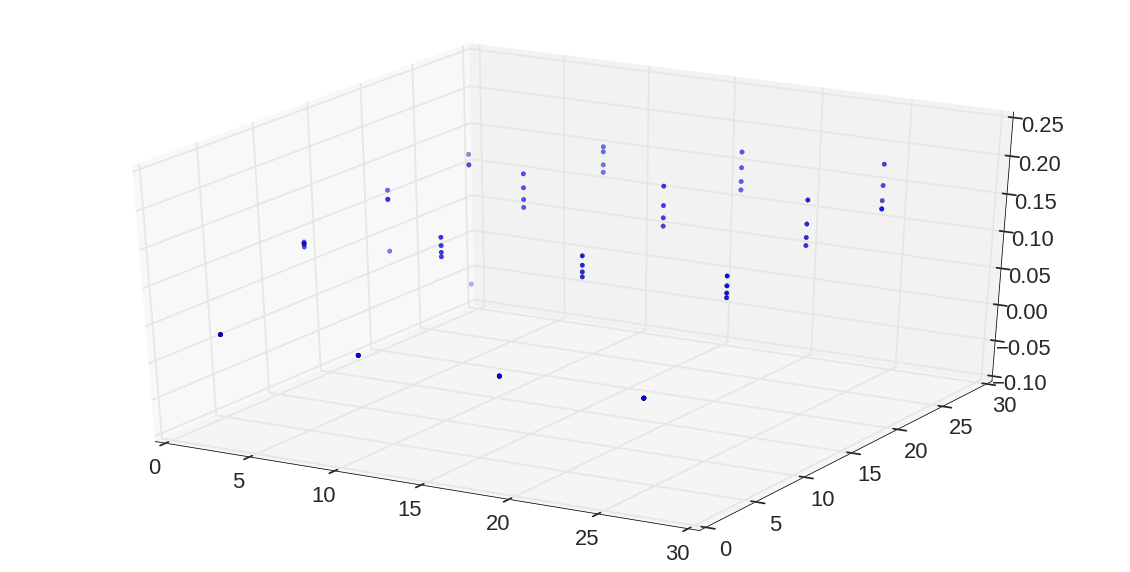

In [92]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,2],results[:,3], marker='o')
plt.show()

Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-2.92611081 -1.84347799 -1.34595238 -1.06165912 -0.51531681  0.22179487
  0.71258853  1.08463999  1.38434066  1.94501121]
Absolute time deviation (in 1k):  4.22660235146


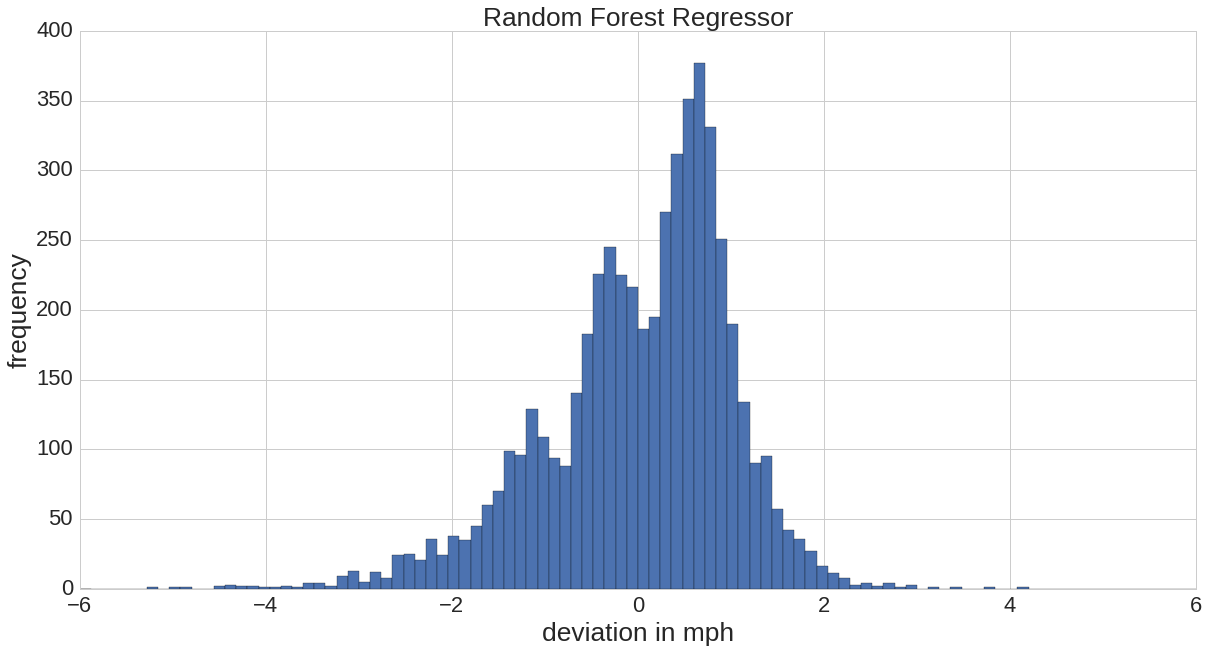

In [93]:
y_pred = rd_regtree.predict(x_test)
np.linalg.norm(np.ceil(y_pred)-y_test)
diff_rd = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff_rd.values, bins=100, range=[-6,6])
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff_rd.values, [1,5,10,15,25,50,75,90,95,99]))
print('Absolute time deviation (in 1k): ', sum(abs(diff_rd))/1000)
plt.title('Random Forest Regressor')
plt.xlabel('deviation in mph')
plt.ylabel('frequency')
plt.savefig('figures/bike_randomforest.png', format='png', dpi=150)

In [94]:
diff_rd.describe()

count    5303.000000
mean        0.021278
std         1.015629
min        -7.083869
25%        -0.515317
50%         0.221795
75%         0.712589
max         4.156410
Name: avg_velocity_mph, dtype: float64

# Dump the best random forest...

In [95]:
from sklearn.externals import joblib
joblib.dump(rd_regtree, 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl', protocol=2)

['randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_01.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_02.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_03.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_04.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_05.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_06.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_07.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_08.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_09.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_10.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_11.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_12.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_13.npy',
 'randforlib/bike_regtree_26x_depth_26_mss_2_PY27.pkl.pkl_14.npy',
 '

In [409]:
! cd randforlib && zip bike_regtree_10x_depth_20.zip bike_regtree_10x_depth_20_PY27.pkl.pkl*

  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl (deflated 67%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_01.npy (deflated 19%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_02.npy (deflated 64%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_03.npy (deflated 77%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_04.npy (deflated 19%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_05.npy (deflated 65%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_06.npy (deflated 77%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_07.npy (deflated 19%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_08.npy (deflated 64%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_09.npy (deflated 77%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_10.npy (deflated 19%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_11.npy (deflated 64%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_12.npy (deflated 77%)
  adding: bike_regtree_10x_depth_20_PY27.pkl.pkl_13.npy (deflated 19%)
  adding: bik